# Processing digital elevation data for deep learning models using Keras Spatial 

#### Aiman Soliman (<asoliman@illinois.edu>) and Jeffrey Terstriep (<jefft@illinois.edu>) 

[National Center for Supercomputing Applications (NCSA)](http://www.ncsa.illinois.edu/) 

[University of Illinois at Urbana-Champaign](https://illinois.edu/), Urbana, Illinois

 

## 1. How to avoid ad hoc preprocessing with Keras Spatial

There are endless possibilities for developing deep learning applications to extract geospatial insights from large remote sensing archives such as [NASA LP DAAC](https://earthdata.nasa.gov/eosdis/daacs/lpdaac) and [NSIDC DAAC](https://nsidc.org/). However, if you have tried to develop your GeoAI application, you must have already stumbled upon the hurdle of getting remote sensing data ready for your deep learning model. Unlike regular images, remote sensing data includes important information about their location, map projection, and coordinate system. Further, rasters tend to be stored in a single file much larger than a single training sample. A common solution around this problem is to ‘chop’ the large remote sensing image in many equal-sized samples. This ad hoc process becomes even more tedious if you would like to repeat the experiment with your GeoAI model as each change of the model input dimensions (i.e., width and height) would require repeating the entire preprocessing steps and duplicating your data. 

In this notebook, you will learn how to avoid these problems by using Keras Spatial, a new python library for preprocessing geospatial data. This library will help you feed your remote sensing data as batches with predefined dimensions, without worrying too much about preprocessing your data in advance. The key point here is that Keras Spatial will handle the projection and the spatial resolution of your remote sensing data and let you specify your input dimensions as if you are handling a regular image. 

## 2. What is Keras Spatial?

Keras Spatial is a [python package](https://github.com/ncsa/keras-spatial) designed to be part of Keras' preprocessing library. It provides capabilities to generate samples and extracting tensor data derived on-the-fly from a raster data source. The most significant design principle for Keras Spatial is the separation of the sample boundary and array size passed to the DL model. The researcher can define a coordinate reference system and sample size in spatial coordinates that are most appropriate to the problem being solved. Following, multiple raster sources can be easily merged together, while re-projection and re-sampling will be done automatically to match the dimensions of the model's input layer.

Following we will discuss with examples the three main components of Keras Spatial: (1) a SpatialDataGenerator (SDG) class that handles access to raster data, (2) Sample definition utilities to aid in the definition of sample boundaries, and (3) Sample Iterator.

In [20]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

### 2.1 Spatial Data Generator

If you are familiar with the deep learning framework [Keras](https://keras.io/), then the SpatialDataGenerator (SDG) resembles the standard [Keras ImageDataGenerator class](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html). The main difference is that SDG extracts sample data from raster files on-the-fly. This approach is more convenient for remote sensing applications, where the dimensions of an input raster file are not equal to the dimensions of a single sample and it may be desirable to extract hundreds or thousands of samples from a single raster. SDG also understands coordinate reference systems and transparently handles reprojection when required. 

In [2]:
from keras_spatial import SpatialDataGenerator

raster_dem = 'http://lidar.ncsa.illinois.edu:9000/test/mclean_roi.tif'   
sdg = SpatialDataGenerator(source=raster_dem)
print(sdg.src.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 19584, 'height': 17027, 'count': 1, 'crs': CRS.from_epsg(3443), 'transform': Affine(5.0, 0.0, 801795.0,
       0.0, -5.0, 1460734.99)}


As can be seen in the final print statement above, the RasterIO src instance is available from the SDG and is useful when inspecting the source raster. The SDG class wraps the RasterIO file class and provides many of the same attributes and methods. In general, the SDG attributes and methods should be preferred as the RasterIO src may be opened and closed automatically during program execution.

Using default parameters, the SDG will return samples in the same coordinate reference system as the source raster. An alternative system can be chosen using the *crs* parameter or *crs* attribute. Similarly *indexes* can be used to specify one or more bands from the source raster. The SDG also supports standard interpolation methods (nearest neighbor, bilinear, cubic, etc) as provided by [the GDAL library](http://www.gdal.org) and the [Rasterio package](https://github.com/mapbox/rasterio). Resampling becomes significant when transforming from raster pixel size to sample size as will be shown in more detail later.

### 2.2 Sample Definition Utilities

In addition to the source raster data, a GeoAI model will require a set of sample boundaries. Samples can be any vector source containing polygons that can be read into a GeoPandas GeoDataframe. If pre-defined boundaries are not available, the Keras Spatial grid module provides two functions for generating GeoDataFrames that define the samples, regular_grid, and random_grid. Both require the spatial extent of the study area, the sample size in the source coordinate units, and the coordinate reference system (CRS). The regular_grid may also include a percentage overlap that increases the number of samples available to model.

The SDG class includes convenience methods that provide a shortcut in accessing these functions where the spatial extent and CRS are determined directly from the raster source. By default, the sample width and height are specified in the native coordinate system units (in this case, feet). Alternatively, samples can be specified in pixels by using the *units='pixels'* parameter.

Regardless of the approach used, the sample boundaries will be defined in spatial coordinates and are **unrelated** to the final array size that will be passed to the model. The sample size should be based on the geometry or physical attributes of the feature being studied. For instance, detecting buildings with sample sizes of 3 by 3 meters may be inappropriate whereas the same sample size may be appropriate for detecting small gullies.

Created 323 samples


,geometry
0,"POLYGON ((806795 1375599.99, 806795 1380599.99..."
1,"POLYGON ((811957.2222222222 1375599.99, 811957..."
2,"POLYGON ((817119.4444444445 1375599.99, 817119..."
3,"POLYGON ((822281.6666666666 1375599.99, 822281..."
4,"POLYGON ((827443.8888888889 1375599.99, 827443..."


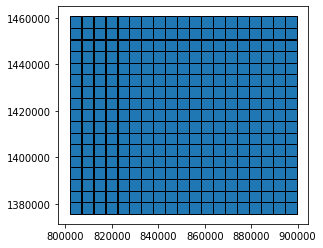

In [3]:
df = sdg.regular_grid(5000, 5000)
print(f'Created {len(df)} samples')

df.plot(color=None, edgecolor='k')
df.head()

Similarly, you could create a dataframe with random samples. In this case, you will need to specify the number of samples in addition to the width and height dimensions of each sample in the native resolution of the SDG source raster. For example, here we created 323 samples as in the regular grid with equal dimensions of 5000 feet. 

Created 323 samples


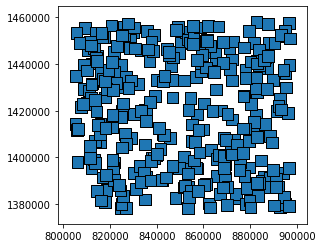

In [4]:
df_rand = sdg.random_grid(5000, 5000, 323)

print(f'Created {len(df_rand)} samples')
df_rand.plot(color=None, edgecolor='k')

### 2.3 Sample Iterator

Developers familiar with ImageDataGenerator may be familiar with the *flow_from_dataframe* method that returns an iterator that reads images from the file system based on the path contained in the dataframe. The SDG *flow_from_dataframe* method performs similarly returning an iterator that performs the following steps:

- Extract sample data from raster source, reprojecting if necessary
- Resample data to match model input size
- Invoke any requested callback functions on each sample
- Stack samples into desired batch sizes

The most important task of the *flow_from_dataframe* generator is to return arrays that match the input size expected by the model. The iterator always returns a NumPy array of shape *(batch_size, height, width, layers)*. *Batch_size, height,* and *width* are parameters passed to the *flow_from_dataframe* method and should be self-explanatory. The *layers* may be indexes (also known as bands) read from the source raster, data created using the SDG callback mechanism, or a combination of the two.

The SDG callback mechanism enables on-the-fly data transformation or augmentation of each sample. A callback can be any function that accepts a NumPy array of shape (1, width, height, n) and returns a NumPy array of shape (1, width, height, m) so the callback may produce new layers. Callbacks are invoked as a pipeline with the results of the earlier callbacks being passed to the subsequent callback. The final callback should always produce an array that matches the model input size.

## 3. A Practical Example: Preprocessing Digital Elevation Models (DEM) 

We will start with a simple example of preparing Digital Elevation Models (DEM) for a landscape morphological classification using a deep learning model. Here we have two input rasters (1) an elevation raster that we want to segment and (2) a label raster that identifies the locations grass waterways, which are commonly found surface hydrology features in agriculture fields. The model produces a binary classification of positions on the landscape that are associated with waterways.

The DEM raster, below, shows the height of every pixel over the Lake Bloomington Watershed area in central Illinois, where the dark pixels are regions with lower elevation.

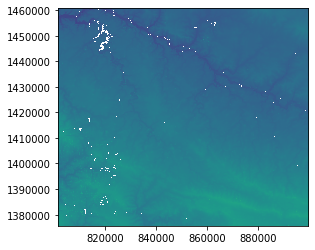

In [5]:
dem_path = 'http://lidar.ncsa.illinois.edu:9000/test/mclean_roi.tif'
dem = SpatialDataGenerator(source=dem_path)
show(dem.src)

The label is a binary raster where light color pixels indicate the locations of the feature of interest, in this case, grass waterways. You should notice that the features are concentrated within the boundaries of the Lake Bloomington Watershed. Areas outside of the watershed were not manually labeled, therefore we can not use them to train the model, and these areas must be excluded from the training and evaluation samples set. It should be also noticed that the geographic projection and spatial resolution of DEM and label rasters are different, but both rasters' units are in feet.

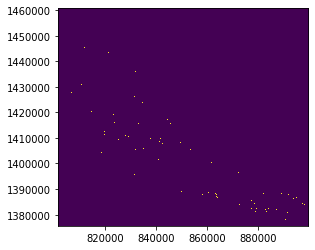

In [6]:
label_path = 'http://lidar.ncsa.illinois.edu:9000/test/labels.tif'
labels = SpatialDataGenerator(source=label_path)
show(labels.src)

### 3.1 Managing sample space 

One of the advantages of using a GeoDataFrame to store the boundaries of the samples is easy filtering and selecting samples to feed to the deep learning model. You can select a subset of samples either by applying a spatial selection criterion (intersection, within, etc.) with an external vector file or by applying a database query on the sample attributes columns. We will discuss how to create sample attributes columns later, but let us start with selecting samples based on spatial relationships. 

#### Selecting samples within an area of interest

Selecting samples based on spatial relationships is useful in the case that the study area has an irregular boundary, or as we mentioned earlier, some areas might have not been included in the manual labeling. Keras Spatial inherited the spatial queries from geopandas, therefore Keras Spatial supports any complicated spatial selection criteria on the samples objects.

We will use the Lake Bloomington watershed as a mask and select only the samples that intersect the watershed boundaries. Notice that you could use a more complicated spatial relationship as a selection criterion, such as selecting samples that fall within, touch, or do not intersect with the boundaries of a vector object. 

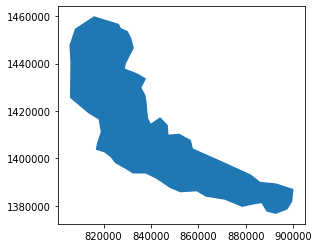

In [7]:
watershed_path = 'http://lidar.ncsa.illinois.edu:9000/test/bloomington_watershed.gpkg'
mask = gpd.read_file(watershed_path)
mask.plot()

Here we select all the samples that intersects our watershed. 

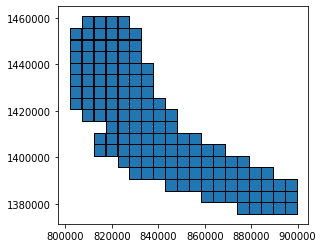

In [8]:
samples = df[df.intersects(mask.unary_union)].copy()
samples.plot(color=None, edgecolor='k')

#### Calculating attributes for each sample

Upon creating a GeoDataFrame for samples, it will contain a single column with the bounding box (geometry) of each sample. A powerful concept in Keras Spatial is setting selection criteria based on sample attributes. This capability comes handy when quantifying class imbalance in training samples, or the geographic bias of samples towards an area with specific attributes, such as specific soil type, average elevation, etc. Once these attributes are added to your GeoDataFrame, selecting samples will be a matter of applying conditional query based on column values as in slicing any DataFrame. The question is how to add the samples attributes to the samples GeoDataFrame?

An easy way to solve this problem is to use the SpatialDataGenerator's iterator to extract samples from the source raster, calculate the attribute for each sample, and store it as a column in the GeoDataFrame. In the following example, the count of labels pixels will be extracted from the label raster and added as a second column named features in the samples' GeoDataFrame. We defined a batch size of one to guarantee a one to one correspondence with every single sample.

,geometry,features
14,"POLYGON ((879066.1111111111 1375599.99, 879066...",0.0
15,"POLYGON ((884228.3333333334 1375599.99, 884228...",0.0
16,"POLYGON ((889390.5555555555 1375599.99, 889390...",16.0
17,"POLYGON ((894552.7777777778 1375599.99, 894552...",222.0
18,"POLYGON ((899715 1375599.99, 899715 1380599.99...",72.0


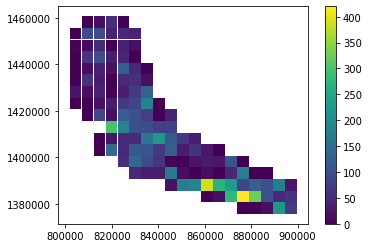

In [12]:
# define label raster as a source raster 
label_path = 'http://lidar.ncsa.illinois.edu:9000/test/labels.tif'  
lsdg = SpatialDataGenerator(source=label_path)

width, height = 128, 128
samples['features'] = [(np.sum(np.where(arr==1, 0, arr) )) 
                    for arr in lsdg.flow_from_dataframe (samples, width, height, batch_size=1)]

samples.plot(column='features', legend=True)
samples.head(5)

The same process could be repeated to add more attributes from other raster files. In the following cell, we calculate the average elevation of each sample. Remarkably, we can add attributes from vector layers as well. For example, a land cover layer could be used to estimate the dominant land cover type of each sample.

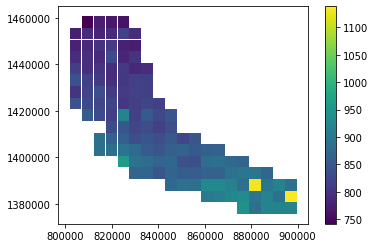

In [13]:
dem_path = 'http://lidar.ncsa.illinois.edu:9000/test/mclean_roi.tif'
rsdg = SpatialDataGenerator(dem_path)

samples['elevation'] = [(np.max(arr)) for arr in rsdg.flow_from_dataframe (samples, 128, 128, batch_size=1)]
samples.plot(column='elevation', legend=True)

### 3.2 Estimating global statistics 

One of the major challenges that you could face when using data generators is estimating global statistics for the entire samples set. For example, in the case that you want to normalize each sample using the global maximum and minimum of the entire data set. This process is difficult because of the piecewise strategy of the data generator to load a batch of samples at a time. Although this strategy uses memory efficiently, it makes the retrieval of global statistics difficult.  

We adopted a two-step solution to solve this problem with Keras Spatial. In the first step, we estimate the local statistical attributes for each sample. In the second step, the global attribute is passed as a parameter to the SDG callback function. 

In the following example, we estimate the global maximum and minimum elevation by first adding two columns with the maximum and minimum elevation for each sample (local statistics) as we demonstrated before. Once the minimum and maximum columns are added to the dataframe, we can estimate the global maximum and minimum directly from the dataframe.

In [26]:
samples['maxelv'] = [(np.max(arr)) for arr in rsdg.flow_from_dataframe (samples, 128, 128, batch_size=1)]
samples['minelv'] = [(np.min(np.where(arr>0, arr, np.nan))) for arr in rsdg.flow_from_dataframe (samples, 128, 128, batch_size=1)]

print(samples.maxelv.max(), samples.minelv.min())

1138.510009765625 733.7999877929688


### 3.3 Sample normalization using a callback function 

Here we define a normalization function and use it as a callback. The first sample is plotted for demonstration purposes.

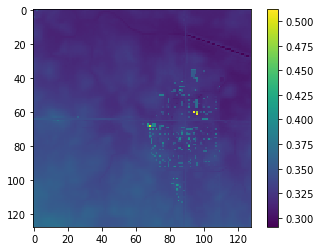

In [27]:
def normalize(arr, gmin, gmax):
    return  (arr - gmin) / (gmax - gmin)
    
sdg.add_preprocess_callback('elvnorm', normalize, samples.minelv.min(), samples.maxelv.max())
gen = sdg.flow_from_dataframe(samples, 128, 128, batch_size=1)
arr = next(gen)

imgplot = plt.imshow(arr[0, :, :, 0], cmap='viridis')
plt.colorbar()

### 3.4 Feeding data directly to train a deep learning model 

After the sample data frame is filtered and all the relevant samples are selected, then it can be used to feed data in a stepwise fashion to the deep learning model. Our final challenge is to provide a tuple containing our label and source data. We use Python's zip function to create a new iterator that is passed to the TensorFlow model.   

In [17]:
# example of Feeding samples to a DL model 
width, height = 128, 128
train_gen = zip(labels.flow_from_dataframe(df, width, height), dem.flow_from_dataframe(df, width, height))

## 4. Conclusion

We introduced Keras Spatial that provides a preprocessing module tailored for remote sensing and geospatial data. Keras Spatial reduces the friction in handling geospatial data by providing loosely coupled preprocessing capabilities to retrieve and transform data on-the-fly before feeding them to deep learning models. Through this notebook, you learned the advantages of using Keras Spatial over more traditional Ad-hoc pipelines, particularly in (1) preparing your samples set in a reproducible way and (2) controlling the sample space and hence avoiding issues such as bias and class imbalance during training. Keras Spatial could also contribute to solving the Geo-AI model bias problem, by providing means to quantify the samples' statistical distribution and estimate the degree of concordance between the statistical distribution of training and prediction datasets to ensure the quality of prediction. Please refer to [(Soliman and Terstriep, 2019)](https://dl.acm.org/doi/10.1145/3356471.3365240) for more information about Keras Spatial. 

## Acknowledgment

This research is based in part upon work supported by the Illinois Natural Resources Conservation Service, Illinois State Geological Survey, and the Illinois State Water Survey.